# COMP30760 Assignment1 - Task 2
# Gearoid Mulligan-19343146

In this assignment we collected matchday related data from four top flight leagues in europe using the Football-Data API. Just so there isn't any confusion I will list the league name, league nation and league code below:

Premier League: English League: PL

League 1: French League: FL1

Seire A: Italian League: SA

LaLiga (Primera Division): Spanish League: PD

This notebook covers Task 2-Data Preparation and Analysis. We will use the JSON files colected in Task 1 as a basis for analysis.

In [1]:
import json
from collections import Counter
from pathlib import Path
from datetime import datetime
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pandas.plotting import scatter_matrix
import seaborn as sns
%matplotlib inline
import statistics

Below is a list of useful key settings and appearence for displaying our data later:

In [2]:
#The nationality of the league
league_full_name=["Premier League","League 1","Seire A","LaLiga"]
#The league codes and file names of our raw data
league_codes=["PL","FL1","SA","PD"]
#We will use a dictionary to color code each league which will help later when analysing
league_colors={"PL":"skyblue","FL1":"tomato","SA":"springgreen","PD":"orange"}
#We will also create a dictionary which shows us the leage associated with each league code
dict_league={"PL":"Premier League","FL1":"League 1","SA":"Seire A","PD":"LaLiga"}
#Set a default font size
font_size=13

Directories for data storage

In [3]:
#Directory for our raw data we found in Task 1
raw_data=Path("raw_data_for_Assignment1")
#We will create a new directory for storing our clean data
clean_data=Path("clean_data_for_Assignment1")
#Make sure this folder exists
clean_data.mkdir(parents=True, exist_ok=True)

# Data Parsing

As there is only one file for each league there is no need to merge files, only parse. As the API contains some data that we dont need we will be focusing on the following information: Home Team, Away Team, Home Win Odds, Away Win Odds, Draw Odds, Home Team Score(HT), Away Team Score(HT), Home Team Score(HT), Away Team Score(HT), Matchday, Winner.

In [4]:
def parse_raw_data(league, league_code, dir_path):
    file_path="%s/%s.json"%(dir_path,league_code)
    f_in=open(file_path,"r")
    json_data=f_in.read()
    matches=json.loads(json_data)
    
    #handle each match instance
    rows=[]
    count=1
    #for loop creates an instance of each match and we store this data as a row
    for m in matches:
        row={"League":league}
        #adding a count function which keeps track of which match it is
        row["Match"]=count
        #adding home and away team names which is very important
        row["Home Team"]=m["homeTeam"]["name"]
        row["Away Team"]=m["awayTeam"]["name"]
        #adding matchday value which indicates which matchday it is
        #A matchday is the collection of days when the matches of that round are played
        #There are typically 38 matchdays in a league of 20 teams, playing everyone twice
        row["Matchday"]=m["matchday"]
        #add betting odds for the match outcome
        row["Home Odds"]=m["odds"]["homeWin"]
        row["Draw Odds"]=m["odds"]["draw"]
        row["Away Odds"]=m["odds"]["awayWin"]
        #There was some issues where half time score was null in the json file
        #and also they were coming out as float numbers which is incorrect
        #I used a simple if statement here to fix this
        if m["score"]["halfTime"]["homeTeam"]==None:
            row["Home Score (HT)"]=0
        else:
            row["Home Score (HT)"]=int(m["score"]["halfTime"]["homeTeam"])
        if m["score"]["halfTime"]["awayTeam"]==None:
            row["Away Score (HT)"]=0
        else:
            row["Away Score (HT)"]=int(m["score"]["halfTime"]["awayTeam"])
        #add final score of the games
        row["Home Score (FT)"]=int(m["score"]["fullTime"]["homeTeam"])
        row["Away Score (FT)"]=int(m["score"]["fullTime"]["awayTeam"])
        row["Winner"]=m["score"]["winner"]
        count+=1
        #add on the newly created row
        rows.append(row)
    #close json file 
    f_in.close()
    
    print("sucessfully parsed data for %s" %league)
    #return back the newly created Data Frame
    return pd.DataFrame(rows)#.set_index("Matchday")

In [5]:
df_leagues={}
for league in league_codes:
    print("--%s"%dict_league[league])
    df_league=parse_raw_data(dict_league[league],league,raw_data)
    df_leagues[league]=df_league.sort_values("Matchday").reset_index(drop=True)
    

--Premier League
sucessfully parsed data for Premier League
--League 1
sucessfully parsed data for League 1
--Seire A
sucessfully parsed data for Seire A
--LaLiga
sucessfully parsed data for LaLiga


# Data Verification

We will check the format of the newly-created Data Frame

In [6]:
df_leagues['PL'].head(12)

,League,Match,Home Team,Away Team,Matchday,Home Odds,Draw Odds,Away Odds,Home Score (HT),Away Score (HT),Home Score (FT),Away Score (FT),Winner
0,Premier League,1,Fulham FC,Arsenal FC,1,5.90,4.28,1.56,0,1,0,3,AWAY_TEAM
1,Premier League,2,Crystal Palace FC,Southampton FC,1,3.17,3.18,2.39,1,0,1,0,HOME_TEAM
2,Premier League,3,Liverpool FC,Leeds United FC,1,1.27,6.15,10.15,3,2,4,3,HOME_TEAM
3,Premier League,4,West Ham United FC,Newcastle United FC,1,2.14,3.44,3.44,0,0,0,2,AWAY_TEAM
4,Premier League,5,West Bromwich Albion FC,Leicester City FC,1,3.87,3.57,1.97,0,0,0,3,AWAY_TEAM
5,Premier League,6,Tottenham Hotspur FC,Everton FC,1,1.88,3.56,4.25,0,0,0,1,AWAY_TEAM
6,Premier League,7,Sheffield United FC,Wolverhampton Wanderers FC,1,3.35,3.00,2.40,0,2,0,2,AWAY_TEAM
7,Premier League,8,Brighton & Hove Albion FC,Chelsea FC,1,5.10,4.12,1.64,0,1,1,3,AWAY_TEAM
8,Premier League,167,Burnley FC,Manchester United FC,1,5.87,4.21,1.55,0,0,0,1,AWAY_TEAM
9,Premier League,182,Manchester City FC,Aston Villa FC,1,1.19,7.70,13.38,0,0,2,0,HOME_TEAM


We can see that some matches are rescheduled as the key and matchday are not in perfect order, i.e 0-9 would have all of matchday 1's. For example you can see the 167th and 182nd match was origionally ment to be played in matchday one but was not played until midway through the season. We will sort continue the DataFrame by Matchday as it keeps it neat.

In [7]:
df_leagues['PL'].tail(5)

,League,Match,Home Team,Away Team,Matchday,Home Odds,Draw Odds,Away Odds,Home Score (HT),Away Score (HT),Home Score (FT),Away Score (FT),Winner
375,Premier League,375,Arsenal FC,Brighton & Hove Albion FC,38,1.63,4.14,5.22,0,0,2,0,HOME_TEAM
376,Premier League,376,Sheffield United FC,Burnley FC,38,2.94,3.47,2.39,1,0,1,0,HOME_TEAM
377,Premier League,377,Leicester City FC,Tottenham Hotspur FC,38,2.01,3.93,3.37,1,1,2,4,AWAY_TEAM
378,Premier League,378,West Ham United FC,Southampton FC,38,1.72,3.98,4.66,2,0,3,0,HOME_TEAM
379,Premier League,380,Wolverhampton Wanderers FC,Manchester United FC,38,2.73,3.48,2.53,1,2,1,2,AWAY_TEAM


We will check to see if all the leagues are the same length (they should be as I purposely chose leagues who had the same number of teams):

In [8]:
for league in league_codes:
    print("Rows in %s:"%league)
    print(len(df_leagues[league]))

Rows in PL:
380
Rows in FL1:
380
Rows in SA:
380
Rows in PD:
380


Check to see if there is any missing values in our Data Fames:

In [9]:
for league in league_codes:
    print("-- %s" % league)
    missing_counts = df_leagues[league].isnull().sum()
    # which coludmns have missing values?
    missing_counts = missing_counts[missing_counts>0]
    if len(missing_counts) == 0:
        print("No missing values found")
    else:
        print(missing_counts)

-- PL
No missing values found
-- FL1
No missing values found
-- SA
No missing values found
-- PD
No missing values found


Seems like everything is in order and we are ready to save the newly created Data Frames!

# Data Saving

We will now save these 'clean' json files in the chosen directory

In [10]:
for league in league_codes:
    file_name="%s.json" % league
    out_path=clean_data/file_name
    print("Writing clean data to %s"%out_path)
    df_leagues[league].to_json(out_path, orient="index", indent=4)
    

Writing clean data to clean_data_for_Assignment1\PL.json
Writing clean data to clean_data_for_Assignment1\FL1.json
Writing clean data to clean_data_for_Assignment1\SA.json
Writing clean data to clean_data_for_Assignment1\PD.json


# Data Analysis

For the first part of this data analysis we will construct a function which can tell us some basic inforamtion aboout a certain column:

In [11]:
def get_stats(column):
    rows=[]
    for league in league_codes:
        row={"League": league}
        row["Min"]=df_leagues[league][column].min()
        row["Max"]=df_leagues[league][column].max()
        row["Mean"]=df_leagues[league][column].mean()
        #row["Median"]=df_leagues[league][column].median()
        row["Standard Deviation"]=statistics.stdev(df_leagues[league][column])
        rows.append(row)
    return pd.DataFrame(rows).set_index("League") 

## Home Win Odds Analysis
Lets have a look at the home win odds column from our data frame

In [12]:
df_home_odds = get_stats("Home Odds")
df_home_odds

,Min,Max,Mean,Standard Deviation
League,,,,
PL,1.11,15.47,2.935000,1.855542
FL1,1.06,13.00,2.670211,1.364085
SA,1.15,10.34,2.942368,1.736994
PD,1.13,15.00,2.804632,1.676470


Lets see what this data looks like on a bar graph:

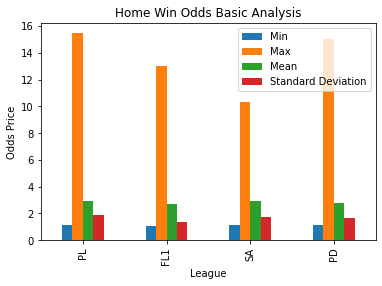

In [13]:
ax=df_home_odds.plot(kind="bar", title="Home Win Odds Basic Analysis",xlabel="League",ylabel="Odds Price")


As you can see from the bar graph above, the mean, standard deviation, median and min are very similar. The only difference can be seen in the max attribute. An explanation for this may be that The max odds may be an ouliar as it clearly lies way outside the standard deviation.

Lets examine the plots for the home odds of each league match over the 4 leagues. I included the average home odds line which we found for each leage above and also the standard deviation line on both sides of the mean which you can see on the graphs below.
Lets first create a function that creates these graphs as we can re-use this for the away and draw odds.

In [14]:
def get_stats_chart(column,max_val):
    
    fig = plt.figure(figsize=(14,7))
    
    #enumerate over league codes to plot a graph for each league
    for i,key in enumerate(league_codes):
        axc = fig.add_subplot(2, 2, i+1)
        ax=df_leagues[key].plot(legend=False,ax=axc,y=column,title=dict_league[key]+" (%s)"%key,color =league_colors[key],ylabel="Odds Price")
        #y limit is the maximum value found from the small data frame created, x is 380 as there is 380 games per league
        ax.set_ylim(0,max_val)
        ax.set_xlim(0,380)
        #using seaborn import to plot the standard deviation and mean
        sns.lineplot(x=df_leagues[key]["Match"],y=df_leagues[key][column].mean(),linestyle='--',label="Average Odds",color="black")
        #using statistics import to calculate standard deviation
        sns.lineplot(x=df_leagues[key]["Match"],y=df_leagues[key][column].mean()+statistics.stdev(df_leagues[key][column]),color="black",label="Standard Deviation")
        sns.lineplot(x=df_leagues[key]["Match"],y=df_leagues[key][column].mean()-statistics.stdev(df_leagues[key][column]),color="black")


    fig.tight_layout()

Now lets run this for our home odds column

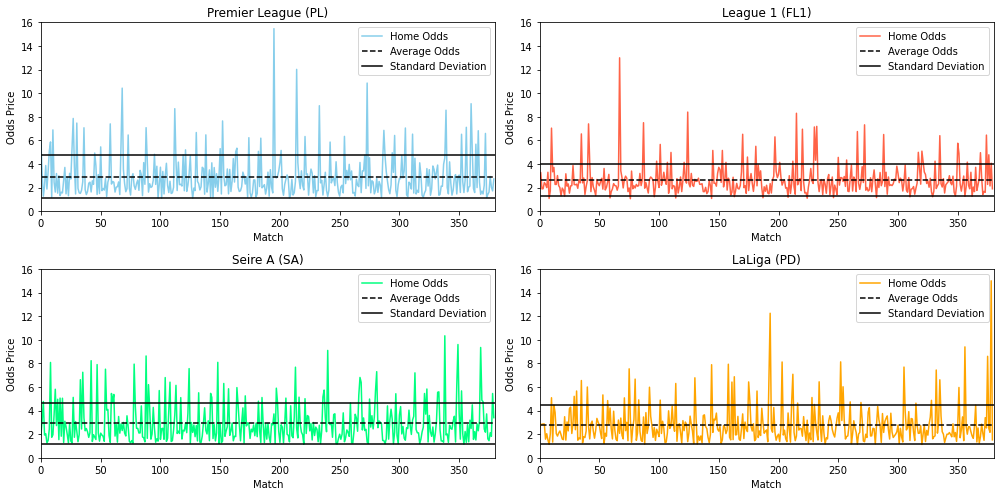

In [15]:
get_stats_chart("Home Odds",16)

From the plots above, we can see that the majority of the home odds lie between the standard deviation. The tightest spread can be seen in the League 1 league which can be backed up by our standard deviation value, this could mean that the league is quite competitive with the odds of each team winning at home being slightly closer when compared the LaLiga or Premier League Graph.

It is important to note also that all the plots do feature some very high skews from the mean. These could represent teams who are not performing well and hence the odds for them winning at home are alot higher. 

Lets see what this data looks like together on one graph:

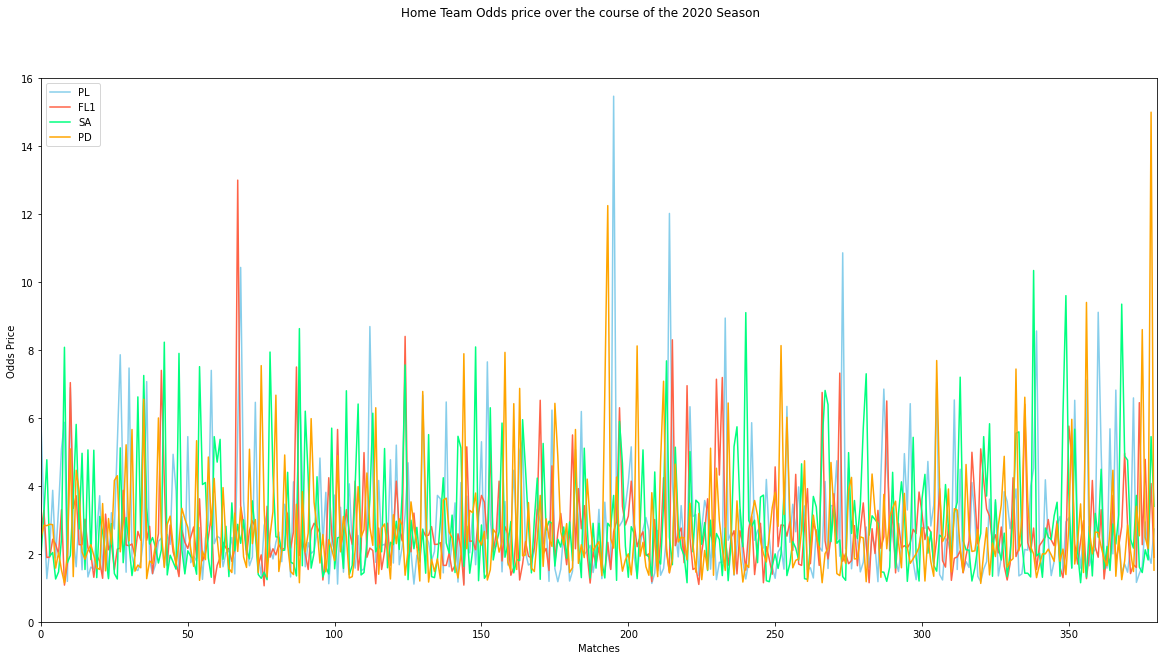

In [16]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)
plt.xlim(0,380)
plt.ylim(0,16)
plt.xlabel("Matches")
plt.ylabel("Odds Price")

#for loop iterates over league code to select each correct column
for key in league_codes:
    plt.plot(df_leagues[key]["Home Odds"],label=key,color =league_colors[key])
    
plt.legend()
plt.suptitle('Home Team Odds price over the course of the 2020 Season')
plt.show()

As I suspected the graph is very hard to read as there is 380 different points of data for each league. Lets look at the matchday trends as there is only 38 data points for each league:

We will again create a function to do this so we can call it again later if needed

In [17]:
df_matchday_home_odds={}
def group_by_matchday(column):
    df_matchday={}
    for league in league_codes:
        #group each row by matchday number
        groups=df_leagues[league].groupby("Matchday")[column]
        max_odds=groups.max()
        min_odds=groups.min()
        average_odds=groups.mean()
        games=groups.size()

        #combine these new values into a seperate new DataFrame
        df_matchday[league]=pd.DataFrame({"Max":max_odds,"Min":min_odds,"Mean":average_odds,"Games":games})
    return df_matchday


Lets see if our function works:

In [18]:
df_matchday_home_odds=group_by_matchday("Home Odds")
df_matchday_home_odds["PL"].head(5)

,Max,Min,Mean,Games
Matchday,,,,
1,5.90,1.19,3.374,10
2,6.89,1.32,2.580,10
3,7.86,1.31,3.363,10
4,7.47,1.41,2.872,10
5,4.93,1.42,2.611,10


It seems to have worked! Lets see if our graph looks any nicer. We will add the max and min data to our graph too to show three different pieces of information about each league on a single graph!

I again will create a function for this as we will reuse this graph for some other columns. The function takes in the newly grouped data frame above and plots them together on the same graph:

In [19]:
def matchday_parsed_graph(matchday_pd,max_val,odds_type):
    f = plt.figure()
    ax = plt.axes()
    ax.set_facecolor("grey")
    f.set_figwidth(20)
    f.set_figheight(10)
    plt.xlim(1,38)
    plt.ylim(0,max_val)
    plt.xlabel("Matchday")
    plt.ylabel("Odds Price")

    for key in league_codes:
        plt.plot(matchday_pd[key]["Mean"],label=key,color =league_colors[key])
        plt.plot(matchday_pd[key]["Max"],label="%s Max"%key,color =league_colors[key],linestyle=':')
        plt.plot(matchday_pd[key]["Min"],label="%s Min"%key,color =league_colors[key],linestyle='--')

    plt.legend()
    plt.suptitle('%s Team Odds price average for each matchday over the course of the 2020 Season'%odds_type)
    plt.show()

Lets see if the function works:

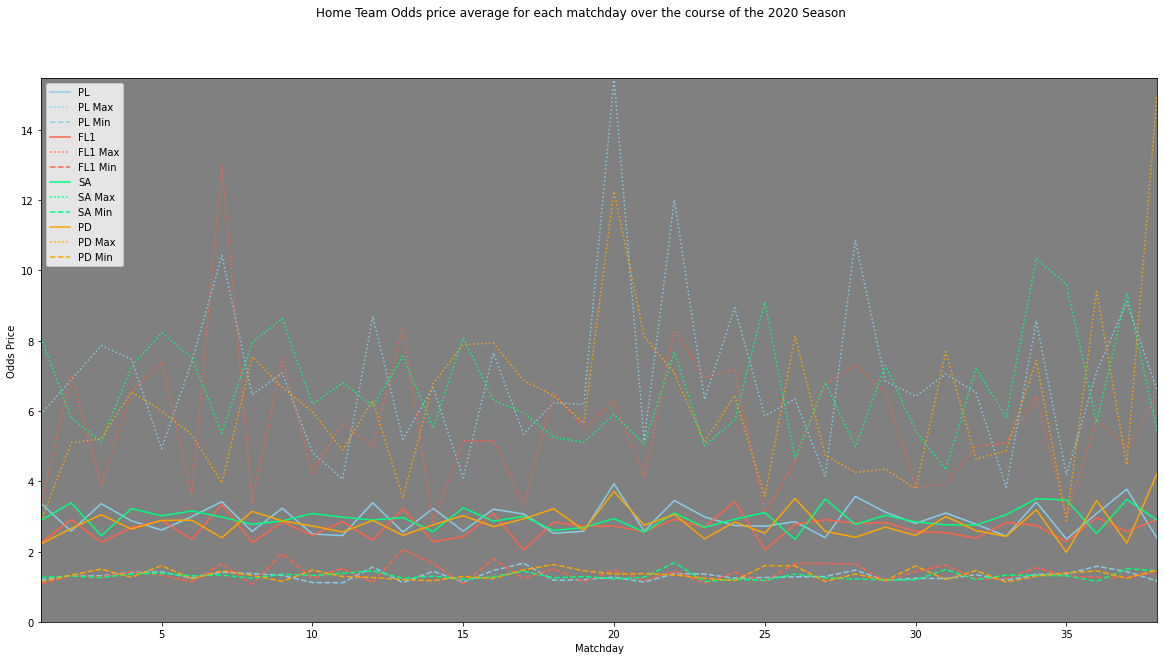

In [20]:
matchday_parsed_graph(df_matchday_home_odds,df_home_odds["Max"].max(),"Home")

As you can see this looks alot better (I changed the background to grey as it much easier to see), we can see from the graph abovethat the French League(League 1(FL1)) has the lowest average home odds as the full red line appears to plot lower. This can be backed up by the FL1 Min line plotting slightly higer than the other leagues but more importantly the FL1 max line tends to plot lower than the rest, bringing the overall mean down.  

This would also suggest why the standard deviation is lower in the Frence League as the average matchday plots above appear to lie closer to its average. In conclusion however, all 4 leagues appear to show similar overall data for home odds.

# Away Win Odds Analysis

Lets do the same analysis but now instead for the away win odds.

Lets again compute the basic stats for the away win odds:

In [21]:
df_away_odds = get_stats("Away Odds")
df_away_odds

,Min,Max,Mean,Standard Deviation
League,,,,
PL,1.17,23.6,4.148711,3.379960
FL1,1.23,39.0,4.171395,3.868200
SA,1.24,18.0,4.035000,2.963296
PD,1.20,59.0,4.234789,3.948499


Lets see what this looks like on a bar graph:

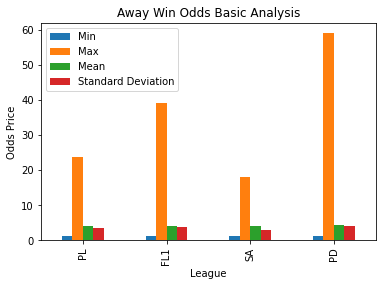

In [22]:
ax=df_away_odds.plot(kind="bar", title="Away Win Odds Basic Analysis",xlabel="League",ylabel="Odds Price")

From the graph we can see that the Spanish League (PD) may have an outliar as its max value appears to be way above the rest while its mean appears to be similar to the other leagues.

Lets have a look at each games away odds:

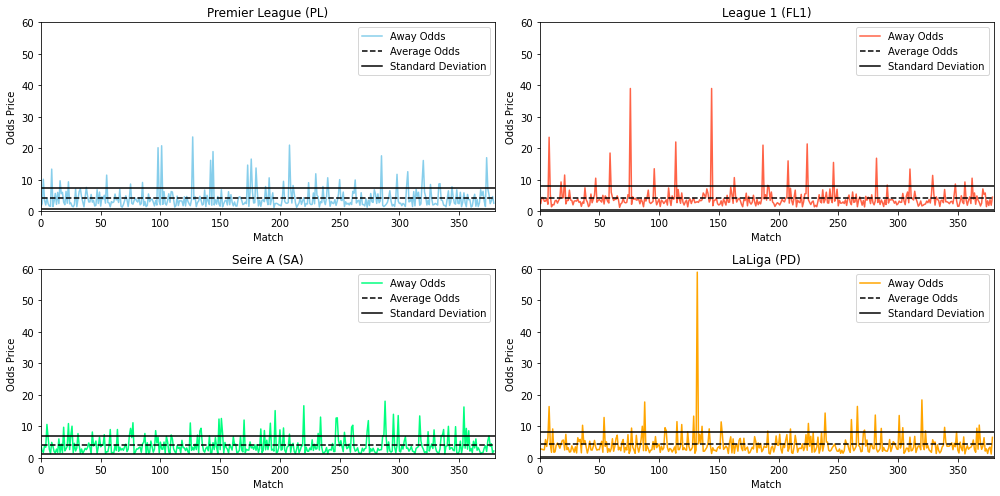

In [23]:
get_stats_chart("Away Odds",round(df_away_odds["Max"].max())+1)

From these graphs again similarly to the home odds it appears that the Italian league, Seire A(SA) has the tighest spread with alot of its plots falling between the mean. The highest skews appear to come from League 1(FL1). It's interesting to note that these skews appear to come in a uniform fashon which could tell us that there is one particular team who isn't performing very well away at home in the eyes of the bookies(odds pricers).

Lets see if this is true by finding the team with the highest away win odds for each matchday in the french league

## Sidenote: Looking at League 1's away odds matchday statistics

Lets use the function we created earlier to group the away odds by matchday

In [24]:
df_matchday_away_odds=group_by_matchday("Away Odds")
df_matchday_away_odds["FL1"].head(5)

,Max,Min,Mean,Games
Matchday,,,,
1,23.50,2.21,5.533,10
2,9.30,1.40,3.587,10
3,11.50,2.02,4.392,10
4,7.45,1.54,3.433,10
5,10.50,1.47,4.032,10


Lets define a function to create a seperate data frame of the teams with the highest frequencies of maximum or minimum odds for either home or away (or draw) over the course of 38 matchdays. i.e if a team has the highest or lowest odds they increment by 1.

In [25]:
def find_matchday_frequency(league_code,col_comparing,team,max_or_min,matchday_df):

    counter=1
    ls=[]
    for i,val in enumerate(df_leagues[league_code][col_comparing]):

        if val == matchday_df[league_code][max_or_min][counter]:
            ls.append(df_leagues[league_code][team][i])
            counter+=1

            if(counter>38):
                break

    rows=[]
    temp=Counter(ls)
    for val in temp:
        row={"Team":val}
        row["Frequency"]=temp[val]
        rows.append(row)

    return pd.DataFrame(rows).sort_values(by="Frequency",ascending=False).reset_index(drop=True).head(5)


The function appears to take in alot of parameters but this is to make it versatile for other matchday odds Data Frames, and leagues.
Lets see our results in a table.

In [26]:
find_matchday_frequency("FL1","Away Odds","Away Team","Max",df_matchday_away_odds)

,Team,Frequency
0,Dijon Football Côte d'Or,6
1,Racing Club de Lens,5
2,FC Metz,3
3,Nîmes Olympique,3
4,FC Lorient,3


As you can see the the team with the most frequent highest away odds per matchday is Dijon. However I thought this would be higher. In fact it would be incorrect to say that there is an outliar in this table. Perhaps theres a certain team that is considerably tougher to beat at home causing this skew in data. Lets change the third parameter in the function above and see...

In [27]:
find_matchday_frequency("FL1","Away Odds","Home Team","Max",df_matchday_away_odds)

,Team,Frequency
0,Paris Saint-Germain FC,16
1,Olympique Lyonnais,7
2,Lille OSC,7
3,Olympique de Marseille,3
4,Stade Rennais FC 1901,2


As you can see from this table above Paris Saint-Germain FC(PSG) was the home team on 16 occasions when the away teams odds were the highest of the matchday. This is more than double that of the next most frequent home team Olympique Lyonnais. This could indicate that PSG were in good form at home last season. We can check this by changing away odds to home odds and max to min in the function above, and also using the home odds matchday dataframe. This will find the team with the lowest home win odds for each matchday, i.e the team with the greatest chance of winning in the eyes of the odds pricer. 

In [28]:
find_matchday_frequency("FL1","Home Odds","Home Team","Min",df_matchday_home_odds)

,Team,Frequency
0,Paris Saint-Germain FC,16
1,Olympique Lyonnais,9
2,AS Monaco FC,4
3,Olympique de Marseille,3
4,Lille OSC,3


This table again solidifies this argument, with PSG having considerably more of the lowest odds at home per matchday. This means that out of the 19 home matches PSG had last season, it had (in the eyes of the bookmaker) the best chance in the league of winning 16 times. Typically the away and home odds would correlate, i.e, if he home win odds are very low then the away win odds would tend to be quite high.

Lets visulaise this for each league and plot a bar chart of the results:

First lets save this data for each league in a new DataFrame

In [29]:
#ct=reating a new dictionary and using it to store relevant data
df_leagues_frequency_homeoddsmin={}
for league in league_codes:
    print("--%s data saved"%dict_league[league])
    df_league_frequency=find_matchday_frequency(league,"Home Odds","Home Team","Min",df_matchday_home_odds)
    df_leagues_frequency_homeoddsmin[league]=df_league_frequency

--Premier League data saved
--League 1 data saved
--Seire A data saved
--LaLiga data saved


Now lets create a bar chart showing these results

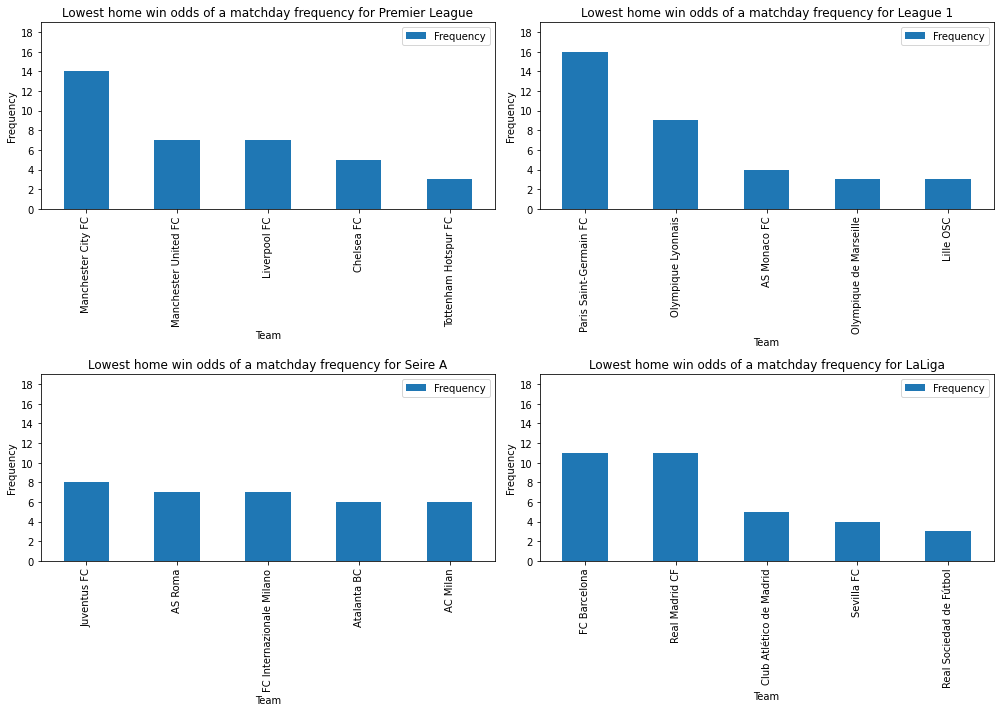

In [30]:
from matplotlib.ticker import MaxNLocator
fig = plt.figure(figsize=(14,10))
for i,league in enumerate(league_codes):
    axc = fig.add_subplot(2, 2, i+1)
    ax=df_leagues_frequency_homeoddsmin[league].plot(ax=axc,x="Team",kind="bar", title="Lowest home win odds of a matchday frequency for %s"%dict_league[league],xlabel="Team",ylabel="Frequency")
    ax.set_ylim(0,19)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
fig.tight_layout()

From these graphs we can see that Mancheser City in the Premier League also had very strong odds at home, indicating that they might have good league home form. The Seire A seems to have a much more competitive graph with no team standing out. This again could back up why it has a low standard deviation and the that league is competitive. LaLiga seems to have two teams who are strong at home, FC Barcelond and Real Madrid.

## Sidenote Over...

Lets complete our analysis of The Away Team Odds by plotting the matchdatay onto a graph to examine:

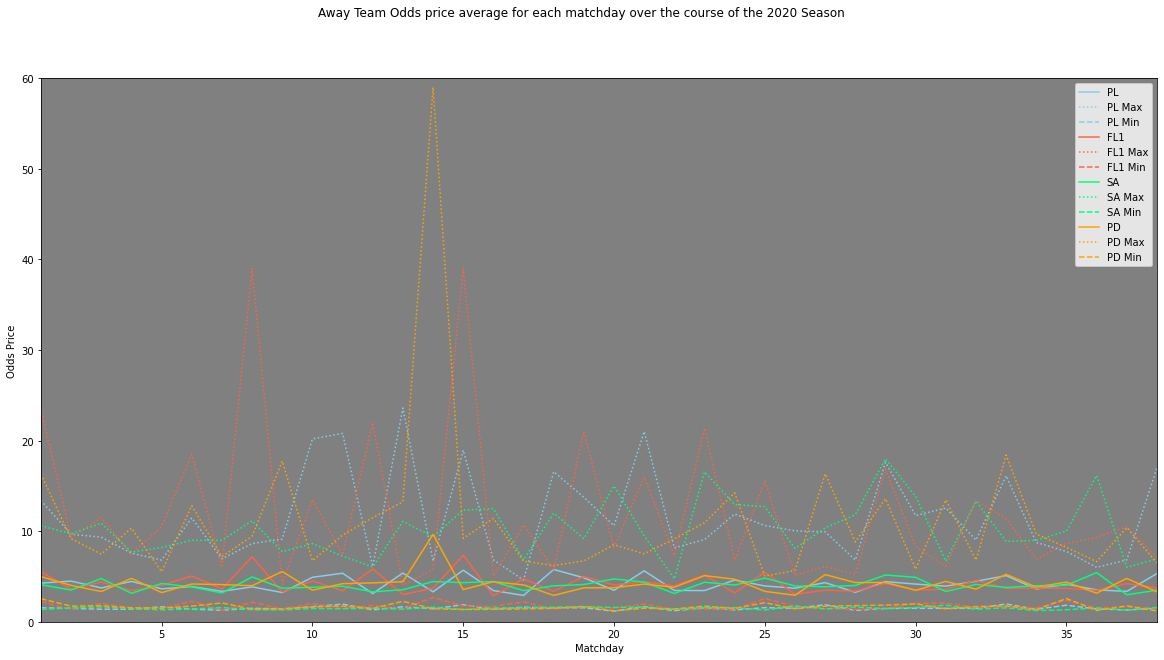

In [31]:
matchday_parsed_graph(df_matchday_away_odds,round(df_away_odds["Max"].max())+1,"Away")

Similarly to the Home Odds data, the SA Away Odds appear to have a much tighter max spread which would indicate why its standard deviation is so low. Its also interesting to point out the affect large spikes in the Max data has to the mean of that particular matchday. This can be seen on matchday 14 of PD, where a huge max away odds caused the overall matchday mean to increase, meaning there is a correlation between the max odds and the average odds of that matchday.

# Draw Odds Analysis

Lets again do the same kind of analysis for the draw odds as the previous home and away odds.

Lest compute some basic stats about the draw odds column for each league.

In [32]:
df_draw_odds = get_stats("Draw Odds")
df_draw_odds

,Min,Max,Mean,Standard Deviation
League,,,,
PL,3.00,10.16,4.045158,1.068635
FL1,2.86,19.00,3.931184,1.534841
SA,2.94,8.40,4.144553,0.952536
PD,2.75,8.68,3.732921,0.979336


Lets visualise this better through a graph

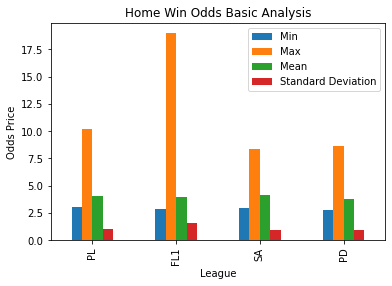

In [33]:
ax=df_draw_odds.plot(kind="bar", title="Home Win Odds Basic Analysis",xlabel="League",ylabel="Odds Price")

From this graph we can see that the french league has the largest max odds by a considerbale amount and a slightly higher standard deviation.

Lets now look at the Draw Odds Price for each league seperately.

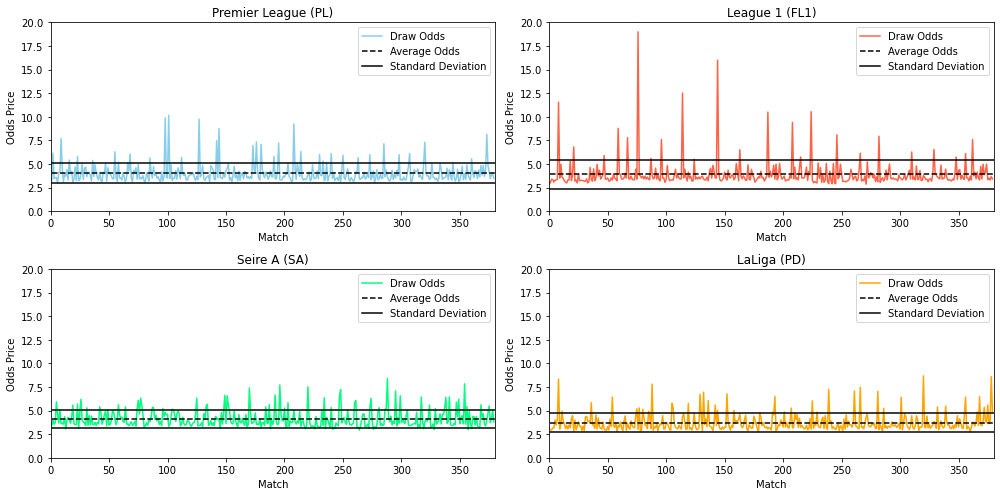

In [34]:
get_stats_chart("Draw Odds",round(df_draw_odds["Max"].max())+1)

The above information shows that the french league, League 1 had some games where the odds for drawing were really high, where as the other leagues max or min values didn't stray too far from the mean. It's interesting to note that no plot in any league appears to fall below the bottom standard deviation. This is due to the fact that it would be impossible for the odds price to fall below 1 as there would be no point in betting (betting €10 on an ods of 0.91 would return a loss of 90c if the bet won).

Lets finally see what this data looks like on the same graph by calculating the rolling matchday mean, max, and min of draw odds.

In [35]:
df_matchday_draw_odds=group_by_matchday("Draw Odds")
df_matchday_draw_odds["PL"].head(5)

,Max,Min,Mean,Games
Matchday,,,,
1,7.70,3.00,4.321,10
2,5.42,3.10,3.977,10
3,5.79,3.26,4.059,10
4,5.39,3.18,4.159,10
5,5.08,3.14,3.842,10


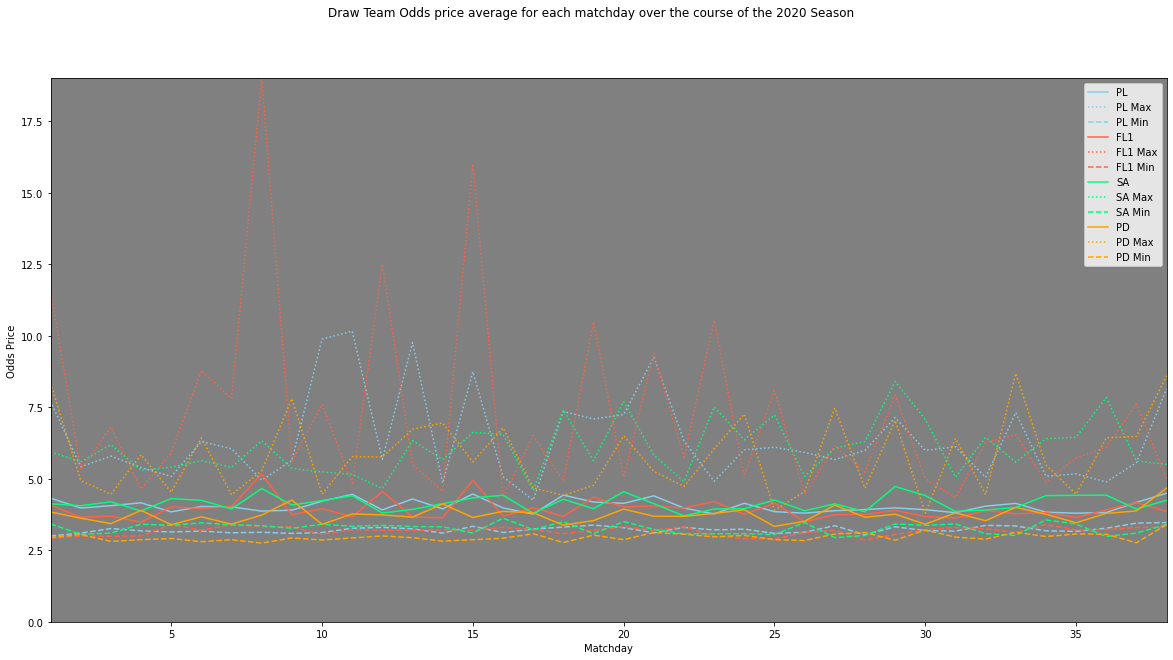

In [36]:
matchday_parsed_graph(df_matchday_draw_odds,df_draw_odds["Max"].max(),"Draw")

From this graph we can see that the FL1 max odds continues its trend of high skews. The leagues min odds also plot very close to the average matchday odds also, meaning most of the data probably lies between the min odds and mean odds. 

# Correlation Between Odds
Lets have a look and see if theres a strong correlation between home, away and draw odds in the same league. I suspect that there will be little correlation accross other leagues but we can still have a look at this.

Lets first create a function to create a seperate data frame with just the odds columns of each league.

In [37]:
def merge_odds():
    col={}
    for league in league_codes:
        #create columns in our new dataframe from the odds columns for each league
        col["Home Odds %s"%league]=df_leagues[league]["Home Odds"]
        col["Away Odds %s"%league]=df_leagues[league]["Away Odds"]
        col["Draw Odds %s"%league]=df_leagues[league]["Draw Odds"]
    #merge the columns and add them onto the eisting columns
    df_merged = pd.DataFrame(col).sort_index()
    
    return df_merged.dropna()

Lets see if it worked:

In [38]:
df_league_odds=merge_odds() 
df_league_odds.head(5)

,Home Odds PL,Away Odds PL,Draw Odds PL,Home Odds FL1,Away Odds FL1,Draw Odds FL1,Home Odds SA,Away Odds SA,Draw Odds SA,Home Odds PD,Away Odds PD,Draw Odds PD
0,5.90,1.56,4.28,2.65,2.99,2.92,1.93,3.85,3.57,2.48,2.98,3.15
1,3.17,2.39,3.18,3.28,2.39,3.02,3.17,2.23,3.42,2.84,2.74,2.99
2,1.27,10.15,6.15,1.89,4.36,3.38,4.77,1.68,4.01,2.83,2.76,2.94
3,2.14,3.44,3.44,1.91,4.25,3.36,1.93,3.88,3.56,2.87,2.56,3.15
4,3.87,1.97,3.57,2.43,3.14,3.08,2.04,3.36,3.72,2.86,2.55,3.16


Lets now see what tihis looks like on a heatmap. A correlation of 1 indicates that there is a direct correlation betwee the two entries. A correlation of -1 indicates that there is a direct negative correlation. A correlation of 0.0 shows no linear relationship between the movement of the two variables.

In [39]:
import numpy as np
def plot_heatmap(title, df_in, figsize=(5.5, 5)):
    df_corr = df_in.corr()
    # create a color palettte
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # display the heatmap
    f, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df_corr, square=True, cbar=False,
                annot=True, cmap=cmap, linewidths=0.5, vmin=-1)
    ax.set_title(title)


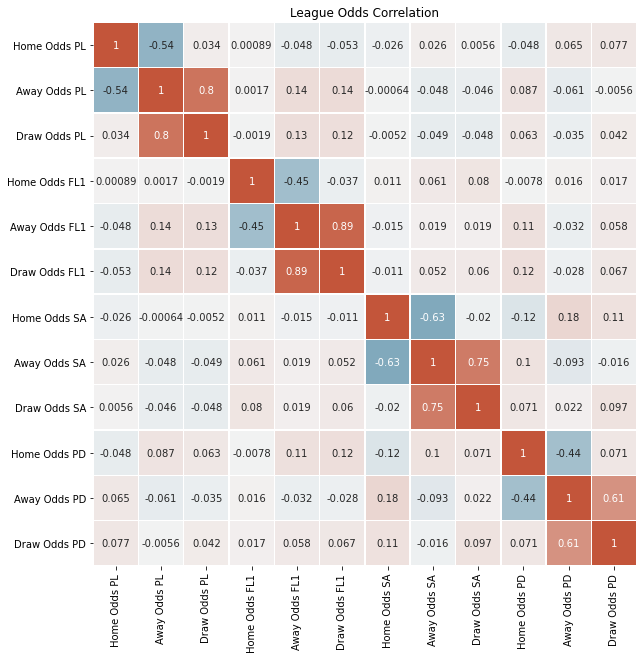

In [40]:
plot_heatmap("League Odds Correlation", df_league_odds, figsize=(10, 10))
    

From the heatmap we can see that there is a strong correlation between the draw odds and away odds in each league, especially in the French League(FL1). We can also see that there is a reasonable negative correlation between the home odds and away odds for each league as I suspected. There is no correlation between the leagues draw odds and home odds. Its interesting to note that there is no correlation accross any of the leagues.

# Score Analysis

For this part of the assignment will include all 4 columns relating to the score (home and away score at both full and half time). 

## Half Time
Lets start by looking at the basic data for the Home Score at Half Time:

In [41]:
def get_stats(column):
    rows=[]
    for league in league_codes:
        row={"League": league}
        row["Min"]=df_leagues[league][column].min()
        row["Max"]=df_leagues[league][column].max()
        row["Mean"]=df_leagues[league][column].mean()
        row["Standard Deviation"]=statistics.stdev(df_leagues[league][column])
        rows.append(row)
    return pd.DataFrame(rows).set_index("League")

In [42]:
df_Home_HT = get_stats("Home Score (HT)")
df_Home_HT

,Min,Max,Mean,Standard Deviation
League,,,,
PL,0,4,0.665789,0.825956
FL1,0,4,0.644737,0.807353
SA,0,4,0.678947,0.835921
PD,0,4,0.628947,0.803491


We can see a very similar statistics for each league, with Seire A having the highest average of goals for the home team at half time by a very slight margin.

In [43]:
df_Away_HT = get_stats("Away Score (HT)")
df_Away_HT

,Min,Max,Mean,Standard Deviation
League,,,,
PL,0,4,0.605263,0.806945
FL1,0,3,0.628947,0.773372
SA,0,5,0.626316,0.797319
PD,0,4,0.526316,0.734985


Again similarly to the home score above theres very similar statistics accross each league, with the Spanish League(PD) having a slightly lower average to the other 3 leagues. 

Lets have a better look at this data and filter it by matchday...

Lets create a new group by matchday function to show some more relevant data between the home and away team goals at half time. Lets see the difference in percentage..

In [44]:
def group_by_matchday_goals(column1,column2):
    df_matchday={}
    for league in league_codes:
        #group each index by matchday number
        groups_home=df_leagues[league].groupby("Matchday")[column1]
        groups_away=df_leagues[league].groupby("Matchday")[column2]
        total=groups_home.sum()+groups_away.sum()
        home=groups_home.sum()
        away=groups_away.sum()
        
        #combine these new values into a seperate new DataFrame
        df_matchday[league]=pd.DataFrame({"Home Goals":home,"Away Goals":away})
    return df_matchday

In [45]:
half_time_goals=group_by_matchday_goals("Home Score (HT)","Away Score (HT)")
half_time_goals["PL"].head(5)

,Home Goals,Away Goals
Matchday,,
1,4,6
2,7,10
3,10,8
4,9,9
5,9,3


Here we can see in macthday 1 in the Premier League, 40% of the goals scored at half time were by the home team and 60% were by the away team.

Lets see what this data looks like on a graph...

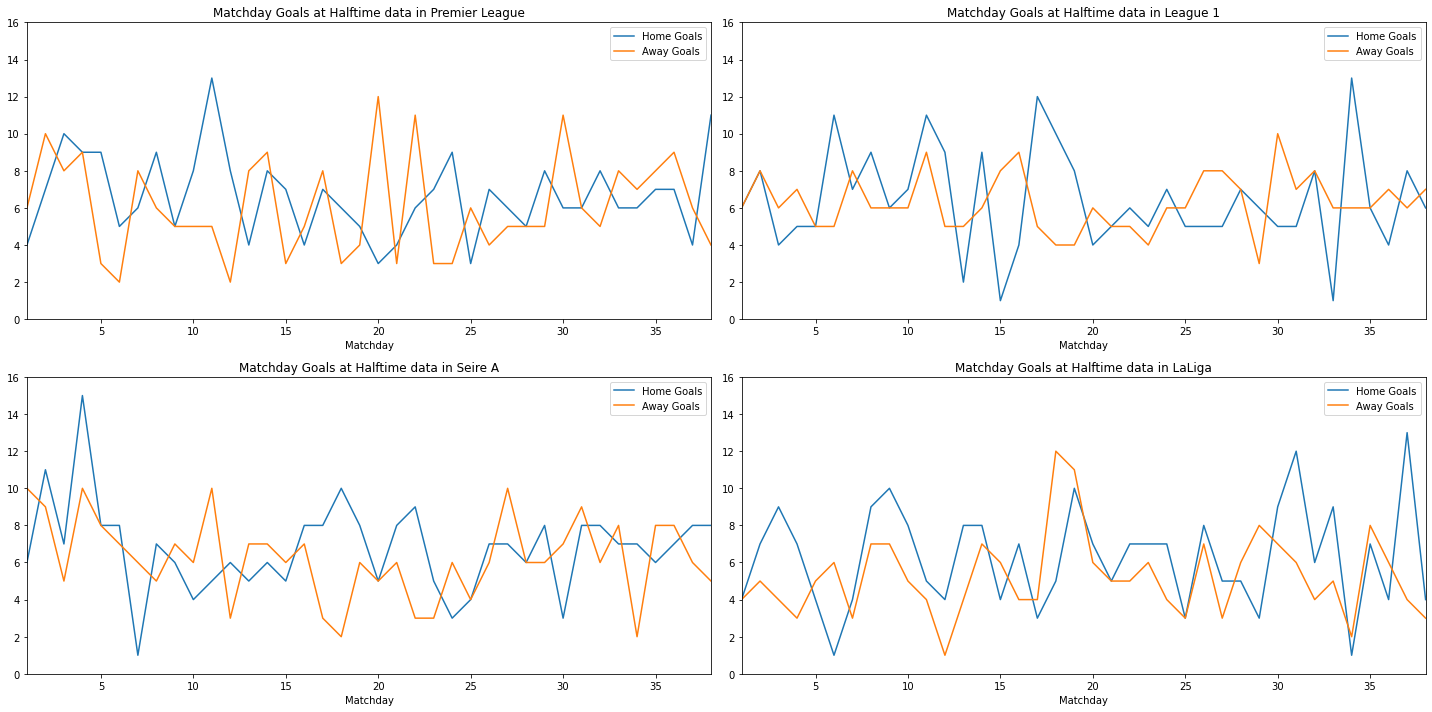

In [46]:
fig = plt.figure(figsize=(20,10))

for i,key in enumerate(league_codes):
    axc = fig.add_subplot(2, 2, i+1)
    ax=half_time_goals[key].plot.line(ax=axc,title="Matchday Goals at Halftime data in %s"%dict_league[key])
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(0,16)
    ax.set_xlim(1,38)
    
fig.tight_layout()

We can see in the Spanish League(laLiga) that there appears to be some points of correlation particurlarly at the middle matchdays. From the graph above we can see that there appears to be more total home goals each matchday accross all of the leagues. Lets check this:

In [47]:
rows=[]
for league in league_codes:
    row={"League": league}
    row["Home Goals"]=df_leagues[league]["Home Score (HT)"].sum()
    row["Away Goals"]=df_leagues[league]["Away Score (HT)"].sum()
    rows.append(row)
df_total_ht=pd.DataFrame(rows).set_index("League")

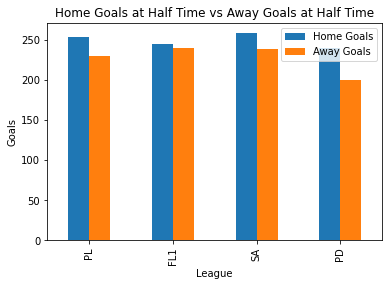

In [48]:
ax=df_total_ht.plot.bar(title="Home Goals at Half Time vs Away Goals at Half Time",ylabel="Goals")


As you can see more goals were scored at halftime by home teams in all leagues, this could maybe tell us that any team at home had a greater chance of scoring than away when looking at each league as a whole. It's interesting to point out that in the French League the difference is very small.

Lets combine all 4 leagues and see what the percentages of goals at halftime look like by constructing a pie chart:

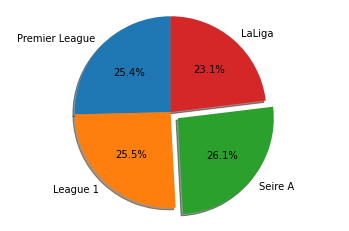

In [49]:
perc=[0,0,0,0]
sum=0
for i,key in enumerate(league_codes):
    sum+=df_total_ht["Home Goals"][key]+df_total_ht["Away Goals"][key]

#get percentages
for i,key in enumerate(league_codes):
    perc[i]=round(((df_total_ht["Home Goals"][key]+df_total_ht["Away Goals"][key])/sum)*100,2)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
#will explode out the biggest piece
explode = (0, 0, 0.1, 0)  

fig1, ax1 = plt.subplots()
ax1.pie(perc, explode=explode, labels=league_full_name, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

We can see from this pie chart that the Seire A has the most goals but it is quite close, edging it out by less than a percent. LaLiga represents just over 23% of the goals which means last season you were slightly less likely to see a goal in the first half compared to the other leagues.

Now lets look at fulll time results.

## Full Time

We will follow the same steps from the half time analysis

Lets get some basic data for the full time score

In [50]:
df_Home_FT = get_stats("Home Score (FT)")
df_Home_FT

,Min,Max,Mean,Standard Deviation
League,,,,
PL,0,9,1.352632,1.320378
FL1,0,6,1.397368,1.216636
SA,0,6,1.634211,1.337658
PD,0,6,1.368421,1.189689


In [51]:
df_Away_FT = get_stats("Away Score (FT)")
df_Away_FT

,Min,Max,Mean,Standard Deviation
League,,,,
PL,0,7,1.342105,1.257722
FL1,0,5,1.363158,1.159888
SA,0,7,1.426316,1.181360
PD,0,6,1.139474,1.057213


Again we see that LaLiga(PD) has a lower mean and standard deviation than the rest. From this data however we can deduce that last seasion there was a very good chance that by ful time a goal was scored by each team as the mean in all rows is above 1.

Lets calculate the goals for each matchday se we can graph a matchday rolling mean comparing the data

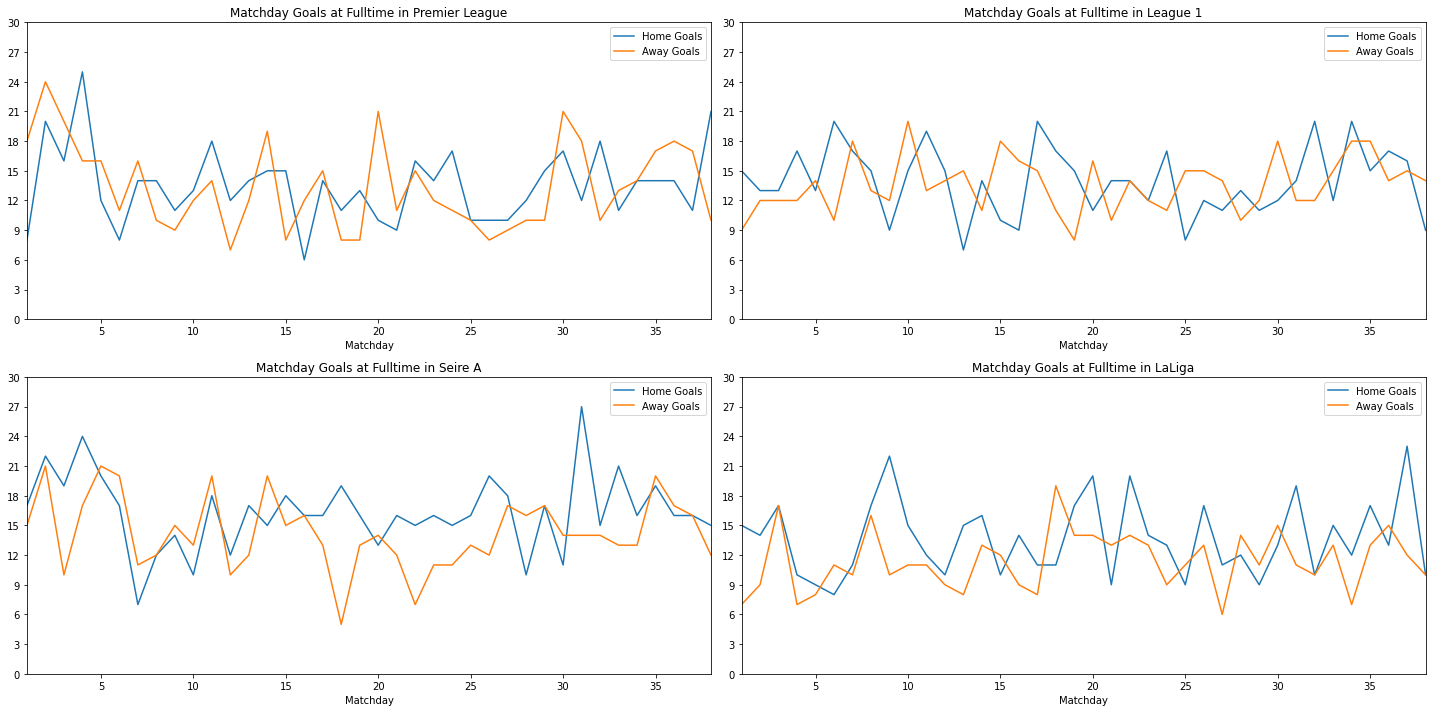

In [52]:
full_time_goals=group_by_matchday_goals("Home Score (FT)","Away Score (FT)")
fig = plt.figure(figsize=(20,10))

for i,key in enumerate(league_codes):
    axc = fig.add_subplot(2, 2, i+1)
    ax=full_time_goals[key].plot.line(ax=axc,title="Matchday Goals at Fulltime in %s"%dict_league[key])
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(0,30)
    ax.set_xlim(1,38)
    
fig.tight_layout()

Similarly to the half time goals analysis, there appears to be overall more home goals than away goals at full time in each of leagues from the graph above. It's interesting to see in the Seire A graph where on some matchdays the difference between home and away goals are quite substantial.

In [53]:
rows=[]
for league in league_codes:
    row={"League": league}
    row["Home Goals"]=df_leagues[league]["Home Score (FT)"].sum()
    row["Away Goals"]=df_leagues[league]["Away Score (FT)"].sum()
    rows.append(row)
df_total_ft=pd.DataFrame(rows).set_index("League")

In [54]:
df_total_ft

,Home Goals,Away Goals
League,,
PL,514,510
FL1,531,518
SA,621,542
PD,520,433


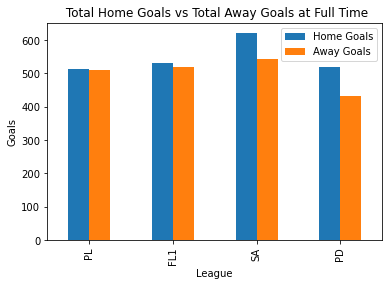

In [55]:
ax=df_total_ft.plot.bar(title=" Total Home Goals vs Total Away Goals at Full Time",ylabel="Goals")


This graph shows us that there is more home goals scored in each league than away goals. Seire A seems to have accumulated the most goals accross the four leagues last season, lets check the percentages..

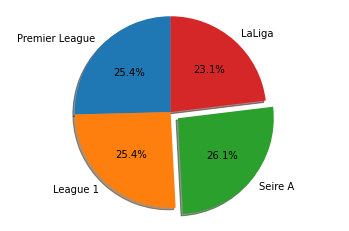

In [56]:
perc=[0,0,0,0]
sum=0
for i,key in enumerate(league_codes):
    sum+=df_total_ft["Home Goals"][key]+df_total_ft["Away Goals"][key]

#get percentages
for i,key in enumerate(league_codes):
    perc[i]=round(((df_total_ht["Home Goals"][key]+df_total_ht["Away Goals"][key])/sum)*100,2)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
#will explode out the biggest piece
explode = (0, 0, 0.1, 0)  

fig1, ax1 = plt.subplots()
ax1.pie(perc, explode=explode, labels=league_full_name, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

From the pie chart we can see that the Seire A league has the most goals by over 2.5% which is pretty substantial. This means that last season you were more likely to see more goals in the Seire A than in any of the other 3 leagues. In footballing terms this could mean many things, one example could be that teams in the Seire A played an attacking style of football which could lead to more chances of scoring. 

# Goals Correlations and Comparisons

Lets examine the total first half goals when compared to the second half time goals

In [57]:
rows=[]
for league in league_codes:
    row={"League": league}
    row["First Half"]=df_leagues[league]["Home Score (HT)"].sum()+df_leagues[league]["Away Score (HT)"].sum()
    row["Second Half"]=df_leagues[league]["Away Score (FT)"].sum()+df_leagues[league]["Home Score (FT)"].sum()-(df_leagues[league]["Home Score (HT)"].sum()+df_leagues[league]["Away Score (HT)"].sum())
    rows.append(row)
df_total=pd.DataFrame(rows).set_index("League")

In [58]:
df_total

,First Half,Second Half
League,,
PL,483,541
FL1,484,565
SA,496,667
PD,439,514


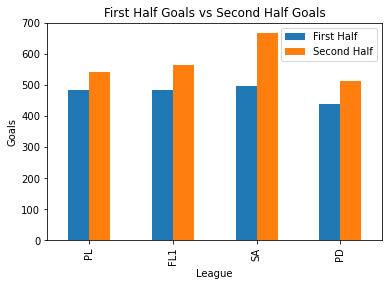

In [59]:
ax=df_total.plot.bar(title="First Half Goals vs Second Half Goals",ylabel="Goals")

We can see that there were considerably more goals scored in the second half in each league, especially in the Seire A.

Lets see the comparison of first half goals and second half goals by matchday..

In [60]:
def group_matchday_goals(column1,column2,column3,column4):
    df_matchday={}
    for league in league_codes:
        #group each index by matchday number
        groups_awayht=df_leagues[league].groupby("Matchday")[column1]
        groups_awayft=df_leagues[league].groupby("Matchday")[column2]
        groups_homeht=df_leagues[league].groupby("Matchday")[column3]
        groups_homeft=df_leagues[league].groupby("Matchday")[column4]
        total_ht=groups_homeht.sum()+groups_awayht.sum()
        total_ft=groups_homeft.sum()+groups_awayft.sum()
        
        #combine these new values into a seperate new DataFrame
        df_matchday[league]=pd.DataFrame({"Half Time":total_ht,"Full Time":total_ft})
    return df_matchday

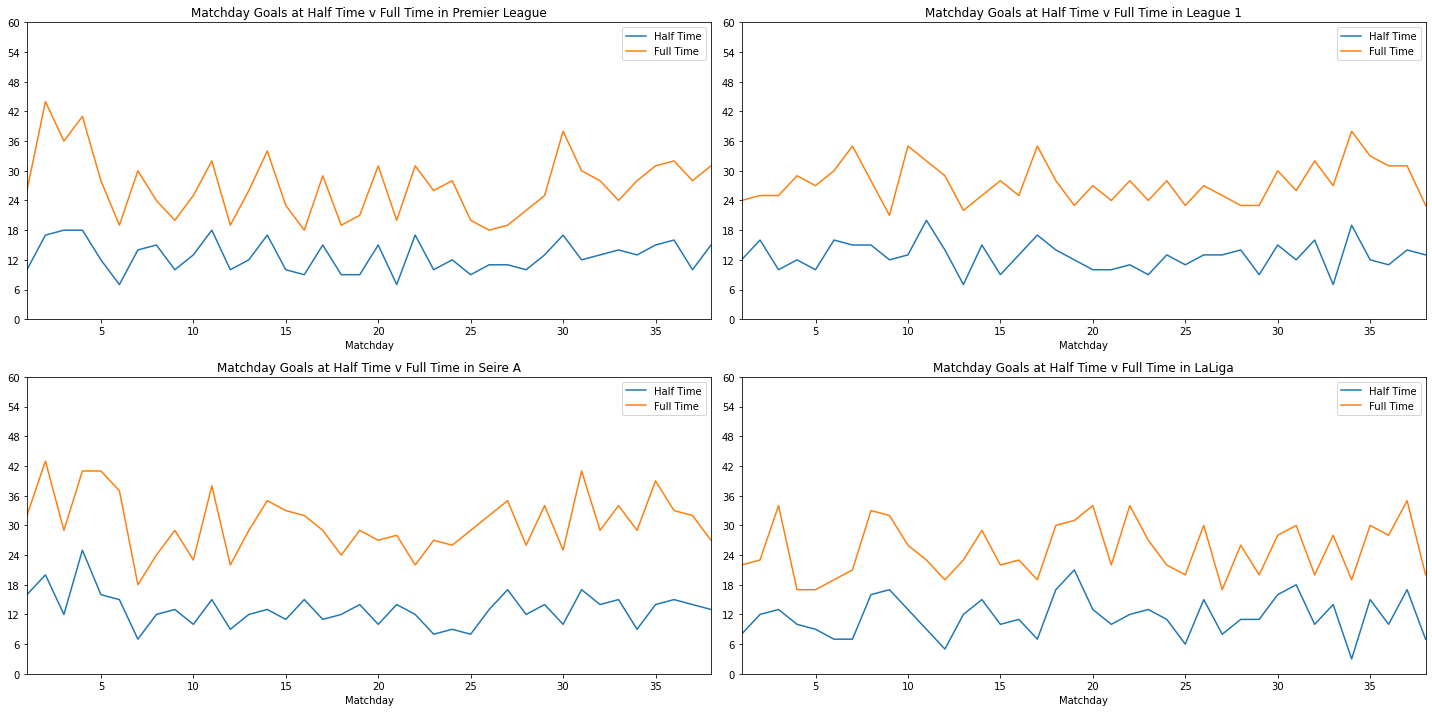

In [61]:
full_time_goals=group_matchday_goals("Away Score (HT)","Away Score (FT)","Home Score (HT)","Home Score (FT)")
fig = plt.figure(figsize=(20,10))

for i,key in enumerate(league_codes):
    axc = fig.add_subplot(2, 2, i+1)
    ax=full_time_goals[key].plot.line(ax=axc,title="Matchday Goals at Half Time v Full Time in %s"%dict_league[key])
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(0,60)
    ax.set_xlim(1,38)
    
fig.tight_layout()

From the graph it looks like there is a great deal of correlation between the first half and second half goals. Lets check this...

Lets merge the home and away odds into one data frame to check correlation

In [62]:
def merge_goals():
    col={}
    for league in league_codes:
        col["Away Score (FT) %s"%league]=df_leagues[league]["Away Score (FT)"]
        col["Away Score (HT) %s"%league]=df_leagues[league]["Away Score (HT)"]
        col["Home Score (HT) %s"%league]=df_leagues[league]["Home Score (HT)"]
        col["Home Score (FT) %s"%league]=df_leagues[league]["Home Score (FT)"]
        
    df_merged = pd.DataFrame(col).sort_index()
    
    return df_merged.dropna()

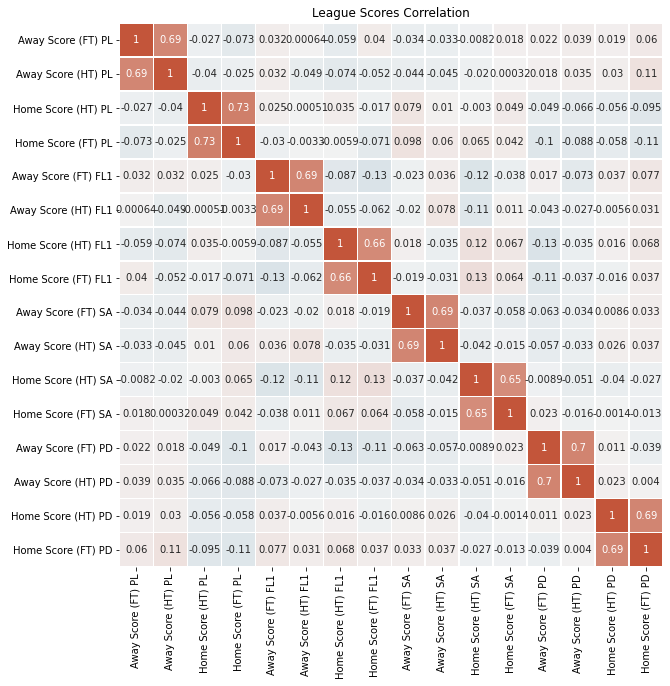

In [63]:
df_league_goals=merge_goals()
plot_heatmap("League Scores Correlation", df_league_goals, figsize=(10, 10))

As I assumed there was a strong correlation between teams half time and full time results, particurlarly in the Premier League. This based on common sense however, if a team scores before halftime, they aren't going to loose a goal and could possibly score another few which would indicate strong correlation.

# Correlaion between odds and goals

Lets check and see in there is a correlation between the betting odds and the scoreline, this should be interesting to see if the bookmakers are correct...

As we have figured out already, there is little correlation between odds and goals outside of their own league so we will seperate these results. We will also just use the full time results as the winner is decided at full time.

In [64]:
def merge_odds_goals(league):
    col={}
    
    col["Away Score (FT) %s"%league]=df_leagues[league]["Away Score (FT)"]
    col["Home Score (FT) %s"%league]=df_leagues[league]["Home Score (FT)"]
    col["Home Odds %s"%league]=df_leagues[league]["Home Odds"]
    col["Away Odds %s"%league]=df_leagues[league]["Away Odds"]
    col["Draw Odds %s"%league]=df_leagues[league]["Draw Odds"]
        
        
        
    df_merged = pd.DataFrame(col).sort_index()
    
    return df_merged.dropna()

In [65]:
df_merged_odds_goals={}
for league in league_codes:
    df_merged_odds_goals[league]=merge_odds_goals(league)
    

Before we look at the heatmaps for the various leagues its important to note that if there is a negative correlation between the home score and the home odds(away score and away odds also) then we could possibly say that the odds are priced well. i.e low odds for the home team indicate that the odds pricers think that they have a strong possibility of winning(scoring goals).

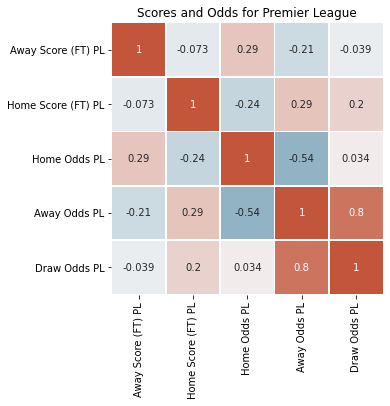

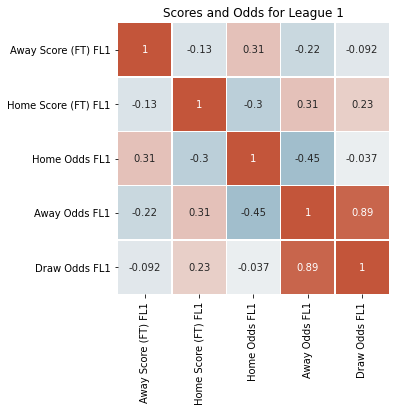

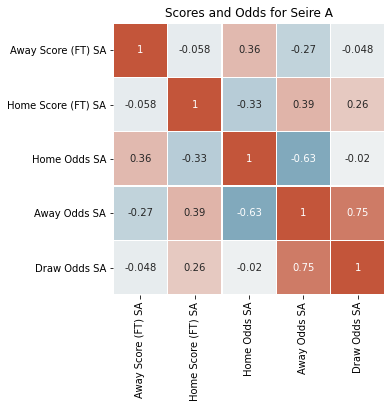

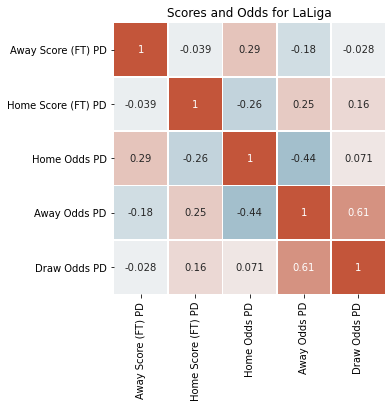

In [66]:
for league in league_codes:
    plot_heatmap("Scores and Odds for %s"%dict_league[league], df_merged_odds_goals[league], figsize=(5, 5))
    

For these heatmaps we are mainly concentrating on squares [3,0],[3,1],[4,0],[4,1]. As you can see from the results there is a slight negative correlation between the home odds and home score and away odds and away score. There is also a slight positive correlation between the home odds and the away score and the away odds and home score. i.e if the away odds are high(away team not that good) the home teams score has a slight tendancy to be high. The strongest correlation for these squares can be seen in the Italian Seire A league.

# Game Winner Analysis
The final part of this assignment will be analysing the results for each league. A league game can result in a win, draw or loss.

Lets create a data frame to display the number of wins draws and losses in a particular league

In [67]:
rows=[]
for league in league_codes:
    row={"League": league}
    row["Home Wins"]=round(df_leagues[league]["Winner"].value_counts().HOME_TEAM,3)
    row["Away Wins"]=round(df_leagues[league]["Winner"].value_counts().AWAY_TEAM,3)
    row["Draws"]=round(df_leagues[league]["Winner"].value_counts().DRAW,3)
    
    rows.append(row)
df_total_wins=pd.DataFrame(rows).set_index("League")


In [68]:
df_total_wins

,Home Wins,Away Wins,Draws
League,,,
PL,144,153,83
FL1,142,143,95
SA,156,128,96
PD,158,113,109


Lets vistalise at this data on a color palette:


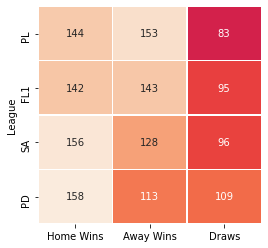

In [69]:
# create a color palettte
cmap = sns.color_palette("rocket", as_cmap=True)
# display the heatmap, with percentages rounded to nearest integer
f, ax = plt.subplots(figsize=(4,4))
h = sns.heatmap(df_total_wins, square=False, cbar=False,
            annot=True, fmt='.0f', cmap=cmap, linewidths=0.5, vmin=0)

We can see that the highest results come from the Home Wins columns, and the least from the draws. Its interesting to note that in the Premier League and French League there were more home wins than away wins which would contradict a common thought that a team would have a better chance of winning when playing at home.

And now the column percentages in a pie chart...

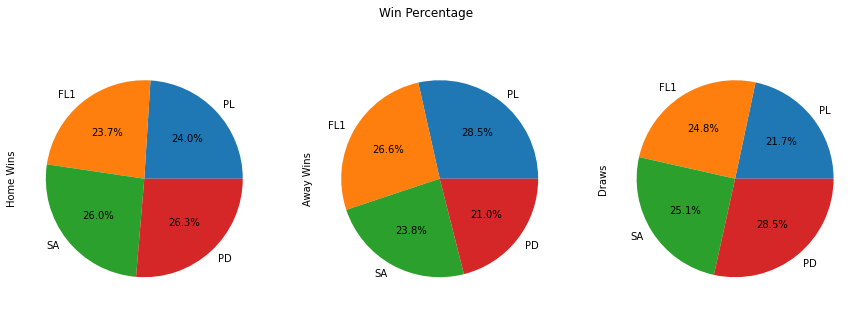

In [70]:
ax=df_total_wins.plot(kind="pie",title="Win Percentage",autopct='%1.1f%%',subplots=True,figsize=(15, 5),legend=False)

We can see from the pie charts that the most home wins came in LaLiga(PD), the most away wins came in the Premier League(PL) and the most draws came in the Italian League Seire A.

# Correlation between Result and Odds
I think it would be interesting to see if we can find how many times the odds favourite won in each league for each particular game. Lets see if we can find this. 

In [71]:
def calculate_favourite():
    rows=[]
    count=0 
    count_l=0
    count_r=0
    for league in league_codes:
        row={"League": league}
        for i,index in df_leagues[league].iterrows():
            #if loops here to check if the favourite won, if they so, increment the counter, the favourite is the result with the lowest odds
            #If statement for home odds favourite
            if (index["Winner"]=="HOME_TEAM")and(index["Home Odds"]<index["Away Odds"])and(index["Home Odds"]<index["Draw Odds"]):
                count+=1
                count_r+=10*index["Home Odds"]
            #If statement for away odds favourite
            elif (index["Winner"]=="AWAY_TEAM")and(index["Away Odds"]<index["Home Odds"])and(index["Away Odds"]<index["Draw Odds"]):
                count+=1
                count_r+=10*index["Away Odds"]
            #If statement for draw odds favourite
            elif (index["Winner"]=="DRAW")and(index["Draw Odds"]<index["Home Odds"])and(index["Draw Odds"]<index["Away Odds"]):
                count+=1
                count_r+=10*index["Draw Odds"]
            else:
                count_l+=1
                count_r-=10
        
        row["Favoured Result Won"]=count
        row["Favoured Result Lost"]=count_l
        row["Win Percentage"]=round((count/380)*100,2)
        row["Return (€10)"]=count_r
        row["ROI Percentage"]=round((count_r/380)*100,2)
        
        rows.append(row)
        count=0
        count_l=0
        count_r=0

    return pd.DataFrame(rows).set_index("League")

I have included a column called Return (€10) which represents your return if you bet €10 on the favourite of each game, and also the win percentage:

In [72]:
df_ods_result=calculate_favourite()
df_ods_result

,Favoured Result Won,Favoured Result Lost,Win Percentage,Return (€10),ROI Percentage
League,,,,,
PL,195,185,51.32,1663.8,437.84
FL1,187,193,49.21,1704.5,448.55
SA,211,169,55.53,2025.3,532.97
PD,203,177,53.42,2039.6,536.74


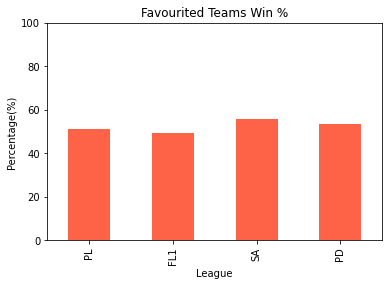

In [73]:
ax=df_ods_result["Win Percentage"].plot(kind="bar",ylabel="Percentage(%)",title="Favourited Teams Win %",color="tomato",ylim=(0,100))

This is quite remarkable. The newly created DataFrame and bar plot shows us here that the favourite won more that 50% of the time in 3 leagues and fell short narrowly in the French League. However, more interestingly when we look at the return figures we see a huge result, they all return a substantial profit, especially in La Liga(PD) where the ROI is over 530%!

These findings lead me to believe that the odds included in this data may be slightly over valued as most odds makers would price the odds in their favour,i.e they would gain an overall profit instead of loosing money.

# Random Statistics

#### Lets see how many times teams lost from winning at half time:

We will use a function similar to the calculate_favourite() function above, but increment count when the winner is the home team and the away team was winning at half time, and vice-versa:

In [74]:
def calculate_lost_HT():
    rows=[]
    count_h=0
    count_a=0
    total=0
    for league in league_codes:
        row={"League": league}
        for i,index in df_leagues[league].iterrows():
            if (index["Winner"]=="HOME_TEAM")and(index["Home Score (HT)"]<index["Away Score (HT)"]):
                count_h+=1
                total+=1
            #If statement for away odds favourite
            elif (index["Winner"]=="AWAY_TEAM")and(index["Away Score (HT)"]<index["Home Score (HT)"]):
                count_a+=1
                total+=1
                
        row["Total Home Team"]=count_h
        row["Total Away Team"]=count_a
        row["Total"]=total
        
        rows.append(row)
        count_a=0
        count_h=0
        total=0

    return pd.DataFrame(rows).set_index("League")

In [75]:
df_lost=calculate_lost_HT()
df_lost

,Total Home Team,Total Away Team,Total
League,,,
PL,9,9,18
FL1,14,9,23
SA,10,9,19
PD,5,8,13


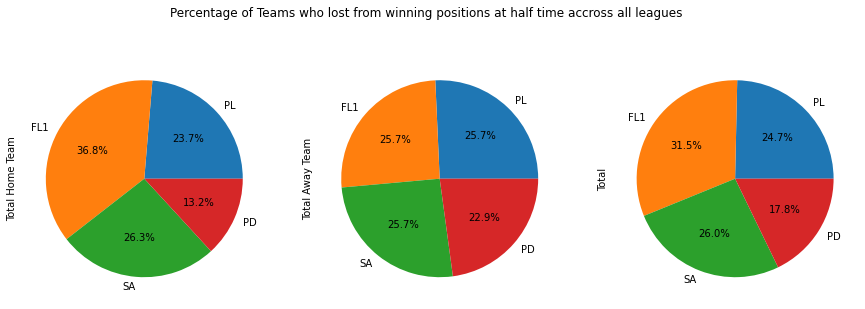

In [76]:
ax=df_lost.plot(kind="pie",subplots=True,autopct='%1.1f%%',legend=False,title="Percentage of Teams who lost from winning positions at half time accross all leagues",figsize=(15, 5))

From this table and pie charts we can see that alot of teams in the French League(FL1) lost from winning positions, especially home teams.

#### Lets see how many times teams won from winning at half time

In [77]:
def calculate_won_HT():
    rows=[]
    count_h=0
    count_a=0
    total=0
    for league in league_codes:
        row={"League": league}
        for i,index in df_leagues[league].iterrows():
            if (index["Winner"]=="HOME_TEAM")and(index["Home Score (HT)"]>index["Away Score (HT)"]):
                count_h+=1
                total+=1
            #If statement for away odds favourite
            elif (index["Winner"]=="AWAY_TEAM")and(index["Away Score (HT)"]>index["Home Score (HT)"]):
                count_a+=1
                total+=1
                
        row["Total Home Team"]=count_h
        row["Total Away Team"]=count_a
        row["Total"]=total
        
        rows.append(row)
        count_a=0
        count_h=0
        total=0

    return pd.DataFrame(rows).set_index("League")

In [78]:
df_won=calculate_won_HT()
df_won

,Total Home Team,Total Away Team,Total
League,,,
PL,94,85,179
FL1,93,91,184
SA,94,80,174
PD,89,63,152


Lets visualise this data on a color palette

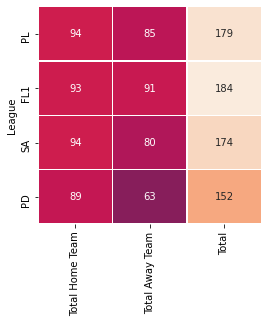

In [79]:
# create a color palettte
cmap = sns.color_palette("rocket", as_cmap=True)
# display the heatmap, with percentages rounded to nearest integer
f, ax = plt.subplots(figsize=(4,4))
h = sns.heatmap(df_won, square=False, cbar=False,
            annot=True, fmt='.0f', cmap=cmap, linewidths=0.5, vmin=0)

We can see from this color pallete that slightly more home teams than away teams won from willing at half time, with the french league having the total most teams who won from winning at half time.

# Conclusion

In this assignment we looked at matchday data from 4 european leagues last season, focusing particurlarly on Odds, Scoreline, and result. As you can see we extracted alot of analysis from the dataset:

From this analysis we found out that there is a strong correlation between goals at half time and full time. We also interestingly found out that there was a strong correlation between the draw odd and away win odds in each league.

We also found out that last season there appeared to be more home wins than away wins in the Spanish and Italian league, but this was not the case for the English and French League where there were more away wins than home wins.

The Covid Pandemic would of had to have had an influence in some of this data too in my opinion, especially with there being no crowds in stadiums allowed for large parts of last season. As a football player myself I know that atmosphere can play a big role in the teams performance especiall if you are awa from home where you might feel intimidated by the home crowd. This could be a reason to why the way wins were so high in the French and English League

Some of the challenges I faced when collecting the data from the API was that at first I found the url address difficult to understand and I was unable to extract the exact data I wanted. It was also frustrating that I was unable to fetch data from matches say two seasons ago as I only had the basic level of API membership

With this particular data there was so much more I could have analysed, here are some ideas:
    
    I could have focused on each league by itslef analysed each teams performance with regards to goals odds and results 
    
    I could have analysed previous seasons and see if last season had similar data or different, with covid being a possible factor as I mentioned.
    
    See if a teams total goals scored correlate to their league finish or if clean sheets factor into their finishing position

In conclusion I think that some of my findings especially the odds related ones were the highlight of this assignment, especially seeing the table of returns if you bet €10 on the favourite.